# Part 1
Test your algorithm on the toy data sets used in this example: http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py, (i.e., your implemented algorithm with the Manhattan distance should add a column to the row of images). Commenting on what you .

In [1]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.cluster import KMeans

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

In [2]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(10 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')
    kmeans = KMeans(n_clusters=params['n_clusters'])

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm),
        ('k-Means', kmeans)
    )

<Figure size 1656x900 with 0 Axes>

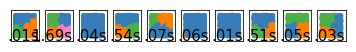

In [3]:
    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

See Project 6.2 for more testing. I could not get the figure to add the column correctly. 

I messed with this entirely too long before doing the Toy Data Sets on my own.

# Part 2 MNIST Fashion NNet

 #### Explain in your own words what is auto-encoding:
 
An autoencoder is a two-part neural network that consists of an encoder and a decoder. This algorithm compresses data (encodes) and the reassembles it as accurately as possible from the compressed data (decodes).   

Basically, auto-encoding takes data, compresses it so that it takes up less space, then rebuilds it with the decoder when needed. It takes the compressed data and attaches nodes to them that can describe the data and be used for classification.  

This is a useful way to reduce noise and dimensionality in image processing.



In [4]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.10.1


## Import the MNIST Fashion Dataset

In [5]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Explore the data

In [7]:
train_images.shape

(60000, 28, 28)

In [8]:
len(train_labels)

60000

In [9]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [10]:
test_images.shape

(10000, 28, 28)

In [11]:
len(test_labels)

10000

### Preprocessing

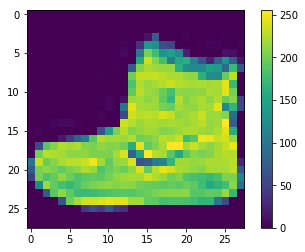

In [12]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)

In [13]:
train_images = train_images / 255.0

test_images = test_images / 255.0

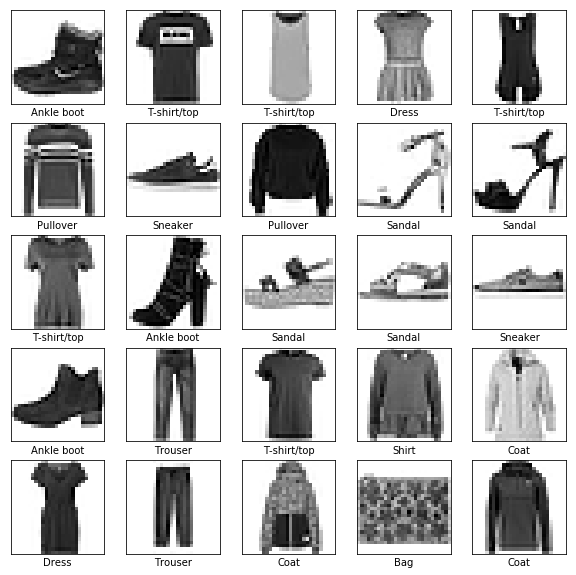

In [14]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

## Model Building

In [15]:
model = keras.Sequential([
    #transform 2d array to 1d array
    keras.layers.Flatten(input_shape=(28, 28)),
    #dense layer with 128 neurons
    keras.layers.Dense(128, activation=tf.nn.relu),
    #10 probability scores for each class
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [16]:
#Compile he model. Add loss function, optimization params, metrics to judge the model
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Model Training

In [17]:
#pass training data to the model
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 2s 34us/step - loss: 0.4982 - acc: 0.8258
Epoch 2/5
60000/60000 [==============================] - 2s 31us/step - loss: 0.3772 - acc: 0.8638
Epoch 3/5
60000/60000 [==============================] - 2s 37us/step - loss: 0.3379 - acc: 0.8756
Epoch 4/5
60000/60000 [==============================] - 2s 34us/step - loss: 0.3152 - acc: 0.8839
Epoch 5/5
60000/60000 [==============================] - 2s 30us/step - loss: 0.2964 - acc: 0.8911


Loss decreases, accuracy increases for each epoch. Processing time drastically decreases after 1st epoch.

### Evaluate Accuracy

In [18]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 16us/step
('Test accuracy:', 0.873)


Training Acc > Test ACC = Overfit model

### Make Predictions

In [19]:
predictions = model.predict(test_images)

In [20]:
#Array of numbers from the Dense Layer with 10 nodes. Highest number is highest probable class.
predictions[0]

array([5.6685749e-05, 7.2016647e-08, 3.2063264e-07, 8.3363734e-09,
       1.6381850e-06, 5.6126587e-02, 4.4751951e-06, 6.1549939e-02,
       5.1044617e-06, 8.8225514e-01], dtype=float32)

In [21]:
#Find the highest value in the array = most likely class of image
np.argmax(predictions[0])

9

In [22]:
#Prediction matches known label
test_labels[0]

9

In [23]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

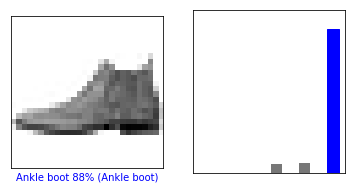

In [24]:
#look at the 0th image, the prediction,and the prediction array
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)


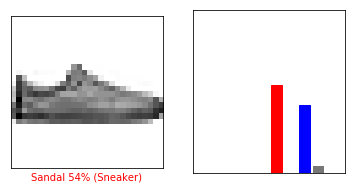

In [25]:
#Look at the 12th image, prediction, and prediction array
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

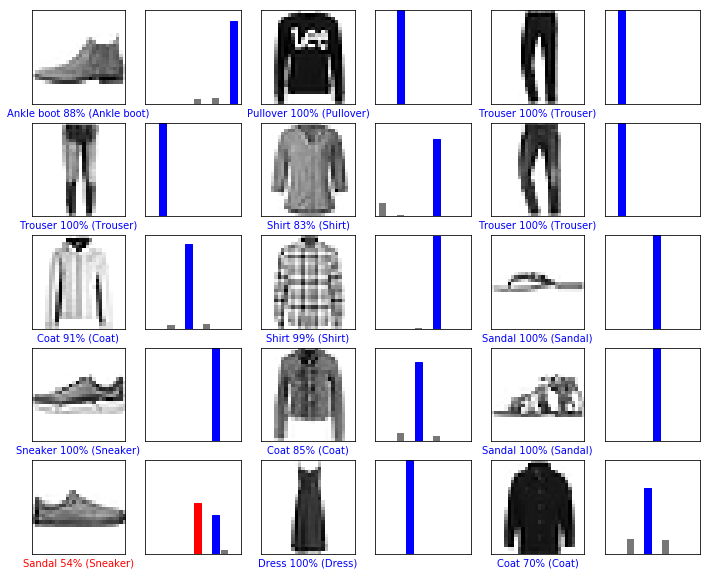

In [26]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [27]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28)


In [28]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [29]:
predictions_single = model.predict(img)

print(predictions_single)

[[5.6685807e-05 7.2016661e-08 3.2063329e-07 8.3363751e-09 1.6381821e-06
  5.6126505e-02 4.4751960e-06 6.1549947e-02 5.1044526e-06 8.8225526e-01]]


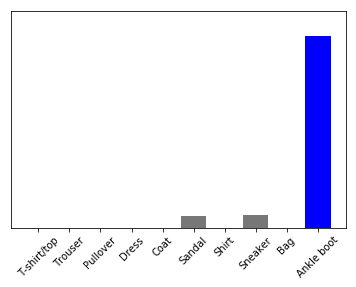

In [30]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [31]:
np.argmax(predictions_single[0])

9

# Part 3
#### Apply unsupervised learning to an appropriate subset data set (i.e. ignore the labels) to see if you can cluster the different types of clothing in this data set.

In [32]:
from sklearn import metrics

In [33]:
# import data into new variables to convert to numpy
(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

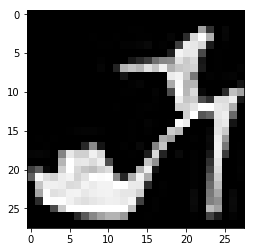

In [34]:
plt.imshow(train_X[9].reshape((28, 28)), cmap = 'gray')

In [35]:
#combine training and test for X and y.
X= np.concatenate((train_X,test_X))
y= np.concatenate((train_y,test_y))

In [36]:
#reshape data for clustering.
X=X.reshape((X.shape[0],-1))
X=np.divide(X,255.)

In [37]:
X.shape

(70000, 784)

In [38]:
y.shape

(70000,)

In [39]:
#define number of clusters (Classes)
n_clusters = len(np.unique(y))
print(n_clusters)

10


In [40]:
#create the model
kmean=KMeans(n_clusters=n_clusters,random_state=0,n_init=20,n_jobs=4)

In [41]:
# train the model
y_hat = kmean.fit_predict(X)

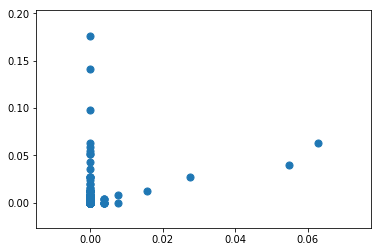

In [42]:
#plot the clusters
plt.scatter(X[:, 0], X[:, 1], s=50);

In [43]:
#calculate accuracy score of model to evaluate
acc = metrics.accuracy_score(y, y_hat)

In [44]:
acc

0.15544285714285713

### Using a simple k-Means algorithm I was only able to reach 15% accuracy for clustering. 